In [1]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install scikit-learn==0.22.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import torch
from torch import nn
import torch.distributions as dist
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import math
import os
import arviz as az
import random
%matplotlib inline

import seaborn as sns
sns.set_style("white")
plt.rcParams.update({'font.size': 9})

import warnings
warnings.filterwarnings("ignore")

np.random.seed(37)
torch.manual_seed(37)
random.seed(37)

## Inverse kinematics problem

The goal is to find configurations of a multi-jointed 2D arm that end in a given position.
The forward process takes a starting height $\xi_1$ and the three joint angles $\xi_2$, $\xi_3$, $\xi_4$, and returns the coordinate of the arm’s end point $f(\boldsymbol{\xi}) = [f_1(\boldsymbol{\xi}), f_2(\boldsymbol{\xi})]$ as 

$$f_1(\boldsymbol{\xi}) = l_1 \cos(\xi_2)+l_2 \cos(\xi_2+\xi_3)+l_3 \cos(\xi_2+\xi_3+\xi_4)$$
$$f_2(\boldsymbol{\xi}) = \xi_1+l_1 \sin(\xi_2)+l_2 \sin(\xi_2+\xi_3)+l_3 \sin(\xi_2+\xi_3+\xi_4)$$

with arm lengths $l_1=0.5,l_2=0.5,l_3=1.0$.

Parameters $\boldsymbol{\xi}$ follow a Gaussian prior $\boldsymbol{\xi} \sim \mathcal{N} (0, \boldsymbol{\sigma}^2.\textbf{I})$ with $\boldsymbol{\sigma} = [0.25, 0.5, 0.5, 0.5]$.The inverse problem is to find the distribution $p(\boldsymbol{\xi} | \textbf{y})$
of all arm configurations $\boldsymbol{\xi}$ that end at some observed 2D position $\textbf{y}$

### Formulation:
$$\textbf{y} = \text{observed variable}$$ 
$$\boldsymbol{\xi} = \text{latent variable}$$
$$\boldsymbol{\xi} \in 	\mathbb{R}^4, \ \textbf{y} \in \mathbb{R}^2 $$
$$p(\boldsymbol{\xi}|\textbf{y}) \propto p(\textbf{y}|\boldsymbol{\xi}) p(\boldsymbol{\xi})$$
$$\text{Prior: } p(\boldsymbol{\xi}) = \mathcal{N} (0, \boldsymbol{\sigma}^2.\textbf{I})$$
$$\text{Likelihood: } p(\textbf{y}|\boldsymbol{\xi}) =  \mathcal{N}(\textbf{y}| f(\boldsymbol{\xi}), \boldsymbol{\gamma}^2.\textbf{I}); \boldsymbol{\gamma} = [0.01, 0.01]$$

In [4]:
xi_dim = 4 
y_dim = 2
noise_scale = torch.tensor([0.01, 0.01])
lens = torch.tensor([0.5, 0.5, 1.0]) # lengths of the kinematic links
prior_scale = torch.tensor([0.25, 0.5, 0.5, 0.5]) # prior scale

# Defining prior distribution
prior_xi_dist = dist.Normal(loc=torch.zeros(xi_dim), scale=prior_scale)

In [5]:
def segment_points(p_, length, angle):
    p = torch.zeros(p_.shape)
    p[:,0] = p_[:,0] + length * torch.cos(angle)
    p[:,1] = p_[:,1] + length * torch.sin(angle)
    return p_, p

def forward_process(xi): # N x d_xi
    """
    Implements the forward process f(xi) and 
    and returns each of the arm’s end points as dictionary.
    """
    values = dict();
    xi = xi.reshape(-1,4)
    A = torch.stack([torch.zeros((xi.shape[0])), xi[:, 0]], axis=1)
    _, B = segment_points(A, lens[0], xi[:,1])
    _, C = segment_points(B, lens[1], xi[:,1] + xi[:,2])
    _, D = segment_points(C, lens[2], xi[:,1] + xi[:,2] + xi[:,3])
    values['A'] = A
    values['B'] = B
    values['C'] = C
    values['D'] = D
    return values;

In [6]:
class ResNet(torch.nn.Module):
    """
    Implements the residual network
    """
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

In [7]:
def unpack_cholesky(L_diag, L_offdiag, xi_dim):
    """
    Constructs cholesky L matrix from diagonal and offdiagonal elements.
    """
    chol_diag = torch.diag(L_diag)
    
    chol_offdiag = torch.zeros((xi_dim, xi_dim))
    tril_indices = torch.tril_indices(row=xi_dim, col=xi_dim, offset=-1)
    chol_offdiag[tril_indices[0], tril_indices[1]] = L_offdiag

    q_L = chol_diag + chol_offdiag # here q_L is L matrix
    return q_L 

In [8]:
class Amortized_VI(nn.Module):
    """
    Class that performs Amortized Variational inference.
    xi_dim: Number of dimensions in the variables to infer.
    y_dim: Number of measurement observations.
    prior_xi_dist: prior distribution defined using torch.distributions.
    f: function defining the forward process.
    noise_scale: Standard deviation of likelihood or the measurement process.
    """
    def __init__(self, xi_dim=4, y_dim=2, prior_xi_dist=None, f=forward_process, noise_scale=torch.tensor([0.01, 0.01])):
        super().__init__()
        
        self.xi_dim = xi_dim
        self.y_dim = y_dim
        self.prior_xi_dist = prior_xi_dist
        self.f = f
        self.noise_scale = noise_scale
        
        self.mu = nn.Sequential(
            nn.Linear(self.y_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, self.xi_dim))
        
        self.L_diag = nn.Sequential(
            nn.Linear(self.y_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, self.xi_dim),
            nn.Softplus()
        )
        
        self.L_offdiag = nn.Sequential(
            nn.Linear(self.y_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, int(self.xi_dim*(self.xi_dim+1)/2)-self.xi_dim)
        )
        
    def observed_data(self, n=30):
        xi_data = self.prior_xi_dist.sample([n])  
        y_data = self.f(xi_data)['D'] + self.noise_scale * torch.randn(*self.f(xi_data)['D'].shape)

        return xi_data, y_data
    
    def forward(self, num_particles=2):
        _, y = self.observed_data(n=32)
        
        q_mu = self.mu(y)
        q_L_diag = self.L_diag(y)
        q_L_offdiag = self.L_offdiag(y) #or 0.01*self.L_offdiag(y)

        #print(q_mu, q_L_diag, q_L_offdiag)
        
        loss = 0
        for j in range(y.shape[0]):
            
            ##### elbo for one data point 
            q_Lj = unpack_cholesky(q_L_diag[j,:], q_L_offdiag[j,:], self.xi_dim) # q_Lj is L matrix    
            
            xi_samples = torch.zeros(num_particles, self.xi_dim)
            for k in range(num_particles):
                zs = torch.randn_like(q_mu[j,:])
                xi_samples[k] = q_mu[j,:] + torch.matmul(q_Lj, zs)# reparametrization

            datafit = 0.
            for i in range(num_particles):
                log_prior = self.prior_xi_dist.log_prob(xi_samples[i]).sum()
                log_likelihood = dist.Normal(loc=self.f(xi_samples[i])['D'][0], scale=self.noise_scale).log_prob(y[j,:]).sum()
                log_joint = log_prior + log_likelihood
                # print(log_prior, log_likelihood)
                datafit += log_joint
            datafit = datafit/num_particles

            entropy = dist.MultivariateNormal(loc=q_mu[j,:], scale_tril=q_Lj).entropy()
            # print(entropy)
            elbo = datafit + entropy
            #####
            loss += elbo
        
        return loss/y.shape[0]

step 0: loss = 21969, learning rate = 0.01000
step 500: loss = 101, learning rate = 0.01000
step 1000: loss = 50, learning rate = 0.01000
step 1500: loss = 135, learning rate = 0.01000
step 2000: loss = 14, learning rate = 0.01000
step 2500: loss = 12, learning rate = 0.01000
step 3000: loss = 17, learning rate = 0.01000
step 3500: loss = 14, learning rate = 0.01000
step 4000: loss = 9, learning rate = 0.01000
step 4500: loss = 27, learning rate = 0.01000
step 5000: loss = 12, learning rate = 0.00100
step 5500: loss = 6, learning rate = 0.00100
step 6000: loss = 7, learning rate = 0.00100
step 6500: loss = 5, learning rate = 0.00100
step 7000: loss = 7, learning rate = 0.00100
step 7500: loss = 6, learning rate = 0.00100
step 8000: loss = 6, learning rate = 0.00100
step 8500: loss = 6, learning rate = 0.00100
step 9000: loss = 6, learning rate = 0.00100
step 9500: loss = 5, learning rate = 0.00100


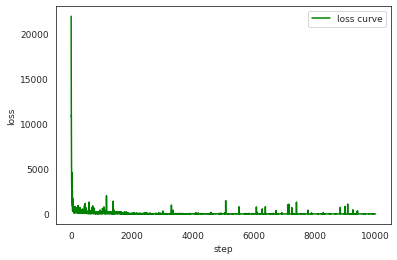

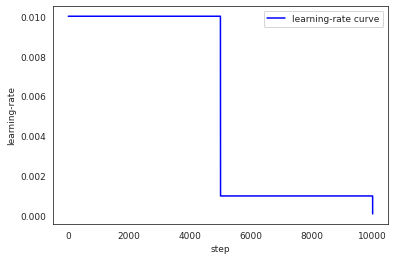

In [9]:
noise_scale = torch.tensor([0.01, 0.01])
model = Amortized_VI(xi_dim=xi_dim, y_dim=y_dim, prior_xi_dist=prior_xi_dist, f=forward_process, noise_scale=noise_scale)

# Training
optim = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=5000, gamma=0.1)

n_steps = 10000

steps, losses, learning_rates = [], [], []
for step in range(n_steps):
    optim.zero_grad()
    loss = - model(num_particles=5)
    loss.backward()
    #torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optim.step()
    scheduler.step()
    
    steps.append(step)
    losses.append(loss.item())
    learning_rates.append(optim.state_dict()['param_groups'][0]['lr'])
    
    if step % 500 == 0: 
        print('step %s:' % step, 'loss = %.0f,' % loss, 
              'learning rate = %.5f' % optim.state_dict()['param_groups'][0]['lr']) 
        
plt.figure()
plt.plot(steps, losses, 'g', label = 'loss curve')
plt.xlabel('step')
plt.ylabel('loss')
plt.legend()

plt.figure()
plt.plot(steps, learning_rates, 'b', label = 'learning-rate curve')
plt.xlabel('step')
plt.ylabel('learning-rate')
plt.legend()

In [10]:
save = True
if save==True:
    torch.save(model.state_dict(), 'model_state_dict_AVI.pt')

In [11]:
noise_scale = torch.tensor([0.01, 0.01])
model = Amortized_VI(xi_dim=xi_dim, y_dim=y_dim, prior_xi_dist=prior_xi_dist, f=forward_process, noise_scale=noise_scale)
model.load_state_dict(torch.load('model_state_dict_AVI.pt'))

<All keys matched successfully>

In [12]:
from post_processing import *    
def plot(xi_samples, xi_data, y_data, j, title, color_code):
    fig = update_plot(xi_samples.data.numpy(), xi_data.data.numpy(), y_data.data.numpy(), lens.data.numpy(), target_label=True, color_code=color_code)
    plt.title(title, fontsize=12)
  
    if save==True:
        plt.savefig(results_dir +str(j)+'_plot'+'.pdf', dpi=300)
        torch.save(xi_samples, results_dir +str(j)+'_xi_samples.pt')
        #xi_samples = torch.load(results_dir +str(j)+'_xi_samples.pt')
    plt.show()
    plt.close()


def pair_plot(df, xi_data, j):
    fig, axes = plt.subplots(len(xi_data[0]), len(xi_data[0]), figsize = (12, 8), sharex="col", tight_layout=True)

    COLUMNS = list(df.columns)
    COLUMNS.remove('Sample type')

    for i in range(len(COLUMNS)):
        for k in range(len(COLUMNS)):
            
            # If this is the lower-triangule, add a scatterlpot for each group.
            if i > k:
                a = sns.scatterplot(data=df, x=COLUMNS[k], y=COLUMNS[i], 
                                  hue="Sample type", ax=axes[i, k], s=10, legend=False)
                a.set(xlabel=None)
                a.set(ylabel=None)

            # If this is the main diagonal, add kde plot
            if i == k:
                b = sns.kdeplot(data=df, x=COLUMNS[k], hue="Sample type",  common_norm=False, ax=axes[i, k])
                axes[i, k].axvline(x=xi_data[0][k], color = 'black', ls ='--')
                b.set(xlabel=None)
                b.set(ylabel=None)

                if k == 0:
                    sns.move_legend(b, "center right", bbox_to_anchor=(5.2,-1.25), title=None,frameon=True,)
                    #sns.move_legend(b, "lower center", bbox_to_anchor=(2.5, 1), ncol=3, title=None,frameon=True,)
                else:
                    axes[i, k].legend([],[], frameon=False)

            # If on the upper triangle
            if i < k:
                axes[i, k].remove()
                     
    for i in range(len(COLUMNS)):
        k=0
        axes[i, k].set_ylabel(COLUMNS[i])

    for k in range(len(COLUMNS)):
        i=len(COLUMNS)-1
        axes[i, k].set_xlabel(COLUMNS[k])

    if save==True:
        plt.savefig(results_dir +str(j)+'_pairplot'+'.pdf', dpi=300)
    # See the chart now
    plt.show()
    plt.close()

0
Groundtruth:
 xi_data=[[-0.13484529  0.4975945   0.44564247 -0.66269284]],
 y_data=[[1.7014114  0.78200763]]
Estimated mean:
[-0.03076786  0.00707483  0.30226597  0.43290502]
Estimated covariance matrix:
[[ 0.00188255 -0.00297794  0.00178187  0.00160804]
 [-0.00297794  0.01015622 -0.0159775   0.0065073 ]
 [ 0.00178187 -0.0159775   0.03498171 -0.02251024]
 [ 0.00160804  0.0065073  -0.02251024  0.01963633]]
---------------
****************


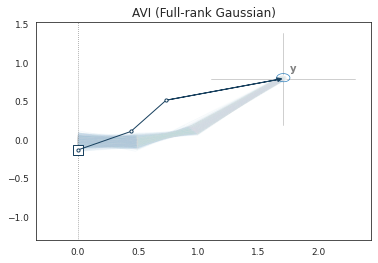

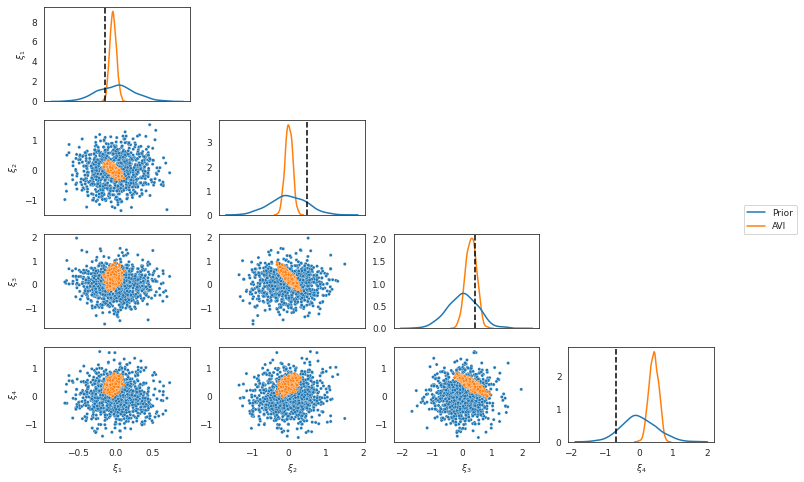

------------------------------------------------------------------------------------------
1
Groundtruth:
 xi_data=[[ 0.42640263  0.01593804 -0.1082748   0.41500935]],
 y_data=[[1.9356389 0.72373  ]]
Estimated mean:
[0.19633386 0.08812293 0.16340473 0.10763788]
Estimated covariance matrix:
[[ 0.00169913 -0.00281003  0.00169398  0.00149162]
 [-0.00281003  0.00998792 -0.01582653  0.00647233]
 [ 0.00169398 -0.01582653  0.03495105 -0.02247493]
 [ 0.00149162  0.00647233 -0.02247493  0.01949404]]
---------------
****************


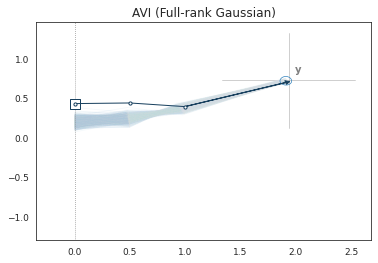

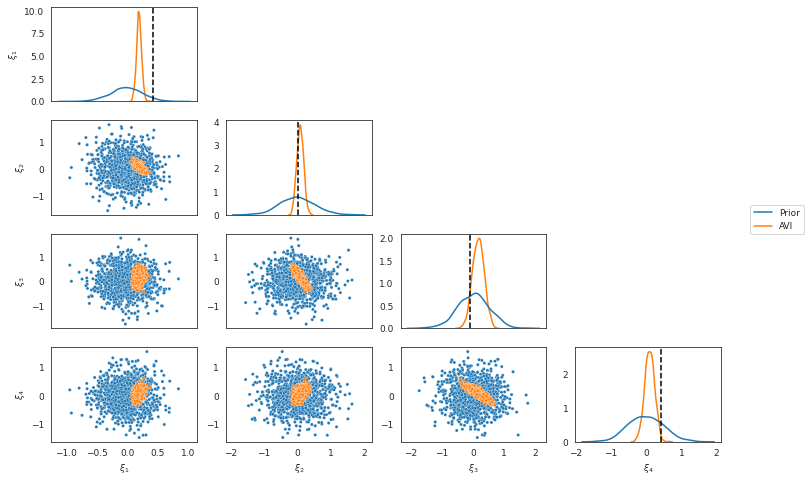

------------------------------------------------------------------------------------------
2
Groundtruth:
 xi_data=[[ 0.18707135  0.7327463  -0.7927243   0.24074735]],
 y_data=[[1.8419003 0.6581068]]
Estimated mean:
[0.04901984 0.01442513 0.23005041 0.2720288 ]
Estimated covariance matrix:
[[ 0.00171552 -0.00278698  0.0017043   0.0014298 ]
 [-0.00278698  0.01000768 -0.01595001  0.00668535]
 [ 0.0017043  -0.01595001  0.03490569 -0.02241738]
 [ 0.0014298   0.00668535 -0.02241738  0.0192257 ]]
---------------
****************


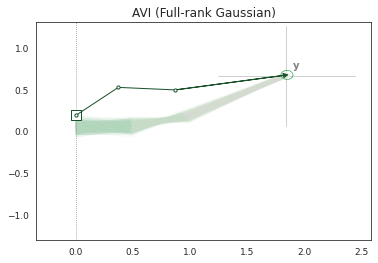

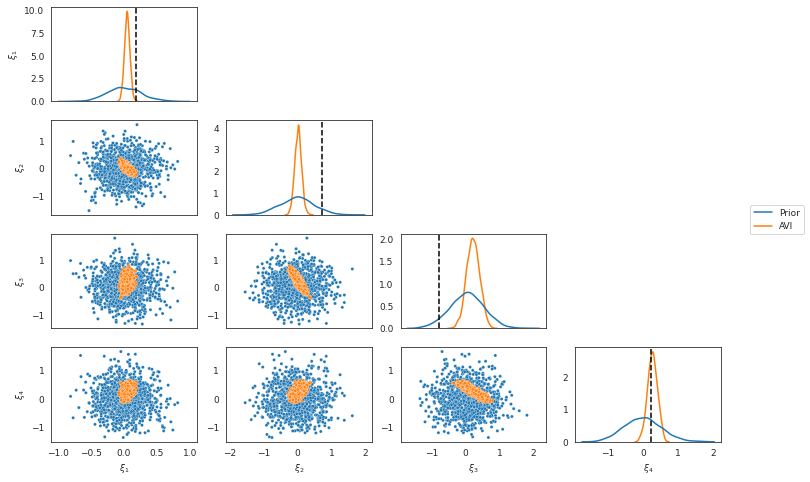

------------------------------------------------------------------------------------------
3
Groundtruth:
 xi_data=[[ 0.04626352 -0.6178119   0.33966345  1.1047677 ]],
 y_data=[[1.5704615  0.34347203]]
Estimated mean:
[-0.45761654 -0.27570772  0.4236498   0.823401  ]
Estimated covariance matrix:
[[ 0.00168783 -0.00222244  0.0017227   0.00039575]
 [-0.00222244  0.00898068 -0.01592524  0.00821132]
 [ 0.0017227  -0.01592524  0.03411926 -0.02152023]
 [ 0.00039575  0.00821132 -0.02152023  0.01597645]]
---------------
****************


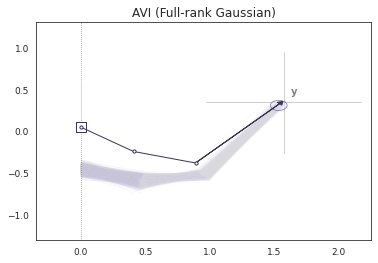

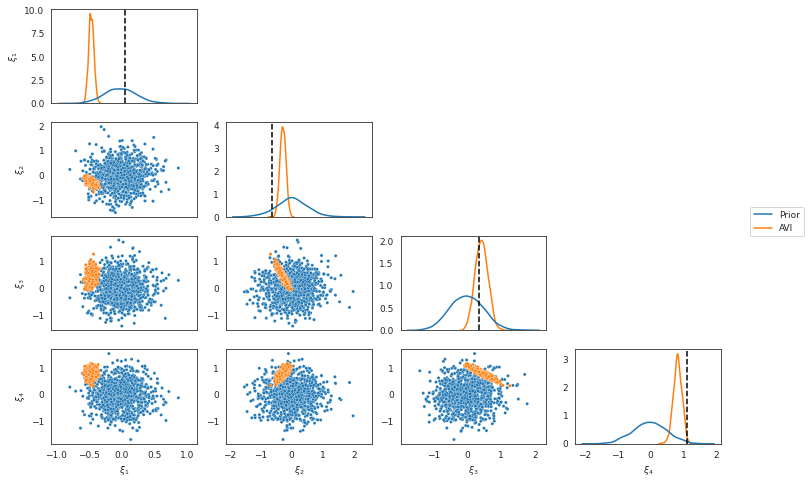

------------------------------------------------------------------------------------------
4
Groundtruth:
 xi_data=[[0.00812608 0.00744829 0.00972763 0.3964704 ]],
 y_data=[[1.9117146  0.42430454]]
Estimated mean:
[ 0.00492951 -0.06696117  0.19262369  0.28002247]
Estimated covariance matrix:
[[ 0.00154122 -0.00228878  0.00163637  0.00068957]
 [-0.00228878  0.00909085 -0.01573306  0.00767044]
 [ 0.00163637 -0.01573306  0.03436173 -0.02179193]
 [ 0.00068957  0.00767044 -0.02179193  0.01685921]]
---------------
****************


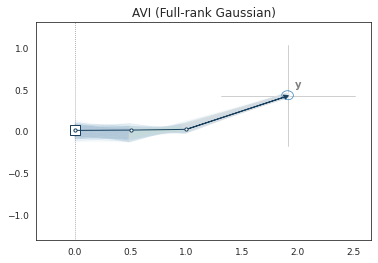

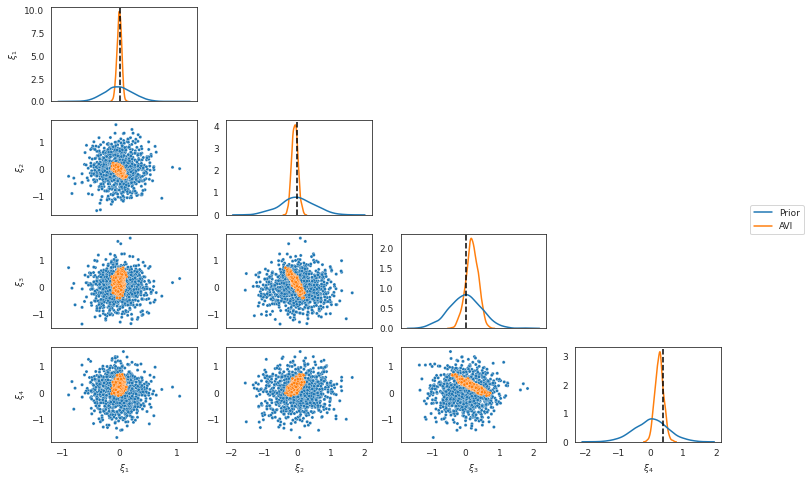

------------------------------------------------------------------------------------------


In [13]:
save = False

n_samples = 1000 # number of posterior samples

for j in range(5):

    print(j)
    
    xi_data, y_data = model.observed_data(n=1)
    print('Groundtruth:\n xi_data='+str(xi_data.data.numpy())+',\n y_data='+str(y_data.data.numpy()))

    mean = (model.mu(y_data))[0, :]
    L_diag = model.L_diag(y_data)
    L_offdiag = model.L_offdiag(y_data) #or 0.01*self.L_offdiag(y)
    L = unpack_cholesky(L_diag[0,:], L_offdiag[0,:], model.xi_dim) # L matrix

    print('Estimated mean:\n'+str(mean.data.numpy()))
    print('Estimated covariance matrix:\n'+str(torch.matmul(L,L.T).data.numpy()))
    
    xi_samples_AVI = torch.zeros(n_samples,model.xi_dim)
    for k in range(n_samples):
        zs = torch.randn_like(mean)
        xi_samples_AVI[k] = mean + torch.matmul(L, zs)
    # print(xi_samples_AVI.shape)

    ######
    # color selection for plotting
    prior=False
    if prior:
        color_code = 4
    else:
        color_code = random.randint(0, 3)

    plot(xi_samples_AVI, xi_data, y_data, j, "AVI (Full-rank Gaussian)", color_code)
    ######

    ######
    Prior_data = prior_xi_dist.sample([n_samples]).T.data.numpy()
    Prior_dict = dict() 
    for i in range(Prior_data.shape[0]):
        Prior_dict[r'$\xi_{%.0f}$' % (i+1)] = Prior_data[i] 

    AVI_data = xi_samples_AVI.T.data.numpy()
    AVI_dict = dict() 
    for i in range(AVI_data.shape[0]):
        AVI_dict[r'$\xi_{%.0f}$' % (i+1)] = AVI_data[i]   

    df_Prior = pd.DataFrame(Prior_dict)
    df_AVI = pd.DataFrame(AVI_dict)
    df_Prior['Sample type'] = 'Prior'
    df_AVI['Sample type'] = 'AVI'

    df = pd.concat([df_Prior, df_AVI])
    df.reset_index(drop=True, inplace=True)
    pair_plot(df, xi_data, j)
    ######
    print('-'*90)

In [14]:
#list(model.named_parameters())

### Comparison of AVI vs MCMC:

In [15]:
import pyro
import pyro.distributions as dist_pyro
from pyro.infer import MCMC, HMC, NUTS

np.random.seed(37)
torch.manual_seed(37)
pyro.set_rng_seed(37)

In [16]:
save=True

results_dir = os.path.join(os.getcwd(), 'results/')
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

In [17]:
xi_data_, y_data_ = model.observed_data(n=5)
print(xi_data_.shape, y_data_.shape)
print('Groundtruth:\n xi_data='+str(xi_data_.data.numpy())+',\n y_data='+str(y_data_.data.numpy()))

torch.save(xi_data_, results_dir +'xi_data.pt')
torch.save(y_data_, results_dir +'y_data.pt')

torch.Size([5, 4]) torch.Size([5, 2])
Groundtruth:
 xi_data=[[ 0.3354301   0.8815546  -0.20953648 -0.42672086]
 [-0.22989541 -0.12536068  0.74884576  0.7099192 ]
 [ 0.07322151 -0.12848109 -0.4071268   0.5861429 ]
 [ 0.03473756  0.33038324 -0.00806682 -0.9201538 ]
 [ 0.03867042  0.7878777  -0.4591129  -0.95894504]],
 y_data=[[ 1.6731473   1.2900836 ]
 [ 1.1469465   0.9599577 ]
 [ 1.92636    -0.18569945]
 [ 1.7687088  -0.20761617]
 [ 1.6315098  -0.04351047]]


0
Groundtruth:
 xi_data=[[ 0.3354301   0.8815546  -0.20953648 -0.42672086]],
 y_data=[[1.6731473 1.2900836]]
0_AVI
Estimated mean:
[0.28218856 0.23470101 0.24171239 0.25805932]
Estimated covariance matrix:
[[ 0.00226462 -0.00394814  0.00191381  0.00305028]
 [-0.00394814  0.01188009 -0.01613692  0.00407869]
 [ 0.00191381 -0.01613692  0.0358787  -0.0236115 ]
 [ 0.00305028  0.00407869 -0.0236115   0.02493253]]
torch.Size([1000, 4])
---------------
****************


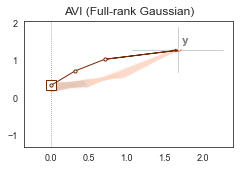

------------------------------------------------------------------------------------------
0_MCMC
torch.Size([1000, 4])
---------------
****************


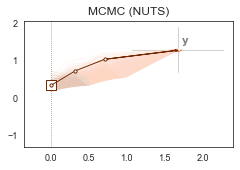

------------------------------------------------------------------------------------------


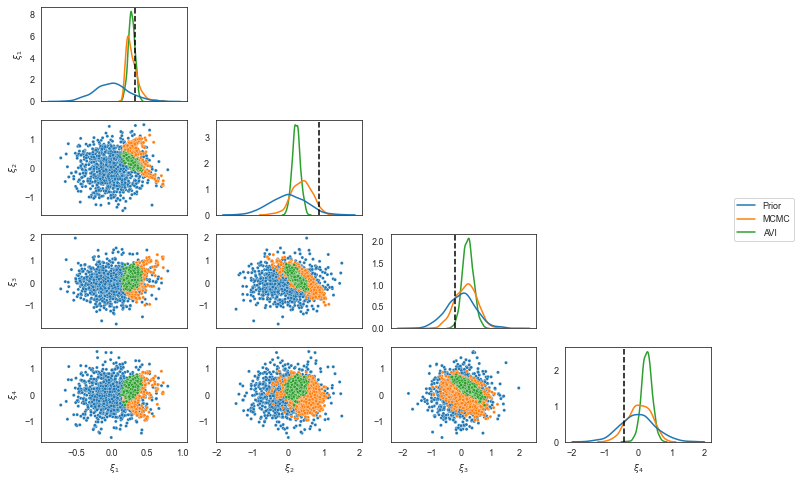

*****************************************************************************************************************************************************************************************
1
Groundtruth:
 xi_data=[[-0.22989541 -0.12536068  0.74884576  0.7099192 ]],
 y_data=[[1.1469465 0.9599577]]
1_AVI
Estimated mean:
[-0.2496877  0.0120742  0.5138787  0.8148494]
Estimated covariance matrix:
[[ 0.00240945 -0.00364488  0.00199947  0.00233966]
 [-0.00364488  0.01133284 -0.01671001  0.00612443]
 [ 0.00199947 -0.01671001  0.0354121  -0.02298718]
 [ 0.00233966  0.00612443 -0.02298718  0.02151806]]
torch.Size([1000, 4])
---------------
****************


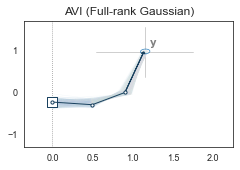

------------------------------------------------------------------------------------------
1_MCMC
torch.Size([1000, 4])
---------------
****************


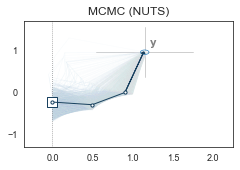

------------------------------------------------------------------------------------------


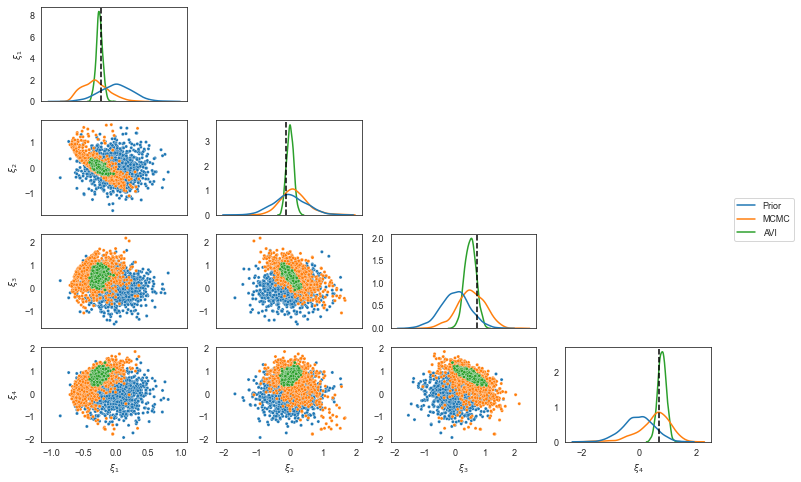

*****************************************************************************************************************************************************************************************
2
Groundtruth:
 xi_data=[[ 0.07322151 -0.12848109 -0.4071268   0.5861429 ]],
 y_data=[[ 1.92636    -0.18569945]]
2_AVI
Estimated mean:
[ 0.06634337 -0.37979364  0.06959747  0.4109144 ]
Estimated covariance matrix:
[[ 0.00123823 -0.00118163  0.00151842 -0.00102305]
 [-0.00118163  0.0075124  -0.01515778  0.00876843]
 [ 0.00151842 -0.01515778  0.0328804  -0.02026696]
 [-0.00102305  0.00876843 -0.02026696  0.01374162]]
torch.Size([1000, 4])
---------------
****************


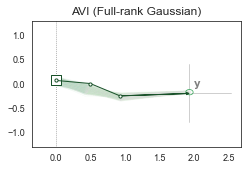

------------------------------------------------------------------------------------------
2_MCMC
torch.Size([1000, 4])
---------------
****************


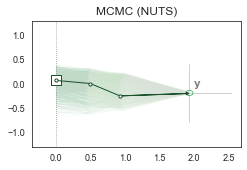

------------------------------------------------------------------------------------------


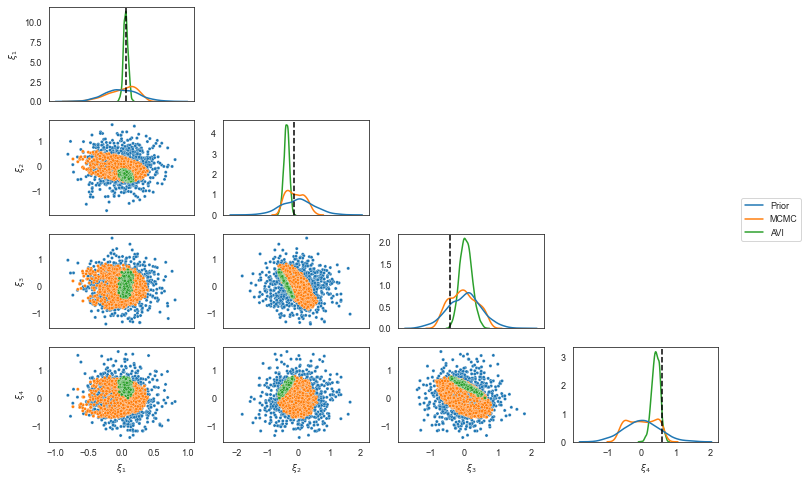

*****************************************************************************************************************************************************************************************
3
Groundtruth:
 xi_data=[[ 0.03473756  0.33038324 -0.00806682 -0.9201538 ]],
 y_data=[[ 1.7687088  -0.20761617]]
3_AVI
Estimated mean:
[ 0.17277506 -0.73272175  0.10629186  0.86302423]
Estimated covariance matrix:
[[ 0.00129963 -0.00115142  0.00155914 -0.00115972]
 [-0.00115142  0.00756886 -0.01523941  0.00882381]
 [ 0.00155914 -0.01523941  0.03281242 -0.02019708]
 [-0.00115972  0.00882381 -0.02019708  0.01371416]]
torch.Size([1000, 4])
---------------
****************


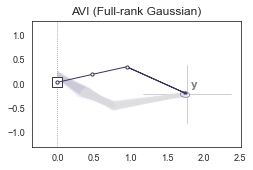

------------------------------------------------------------------------------------------
3_MCMC
torch.Size([1000, 4])
---------------
****************


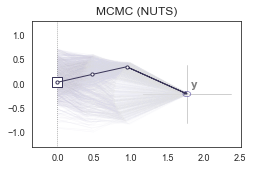

------------------------------------------------------------------------------------------


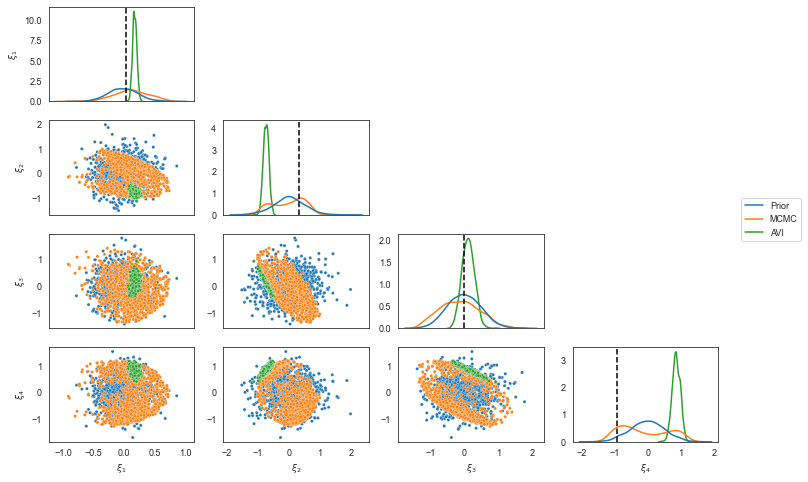

*****************************************************************************************************************************************************************************************
4
Groundtruth:
 xi_data=[[ 0.03867042  0.7878777  -0.4591129  -0.95894504]],
 y_data=[[ 1.6315098  -0.04351047]]
4_AVI
Estimated mean:
[ 0.12234017 -0.68548465  0.17813337  0.9549595 ]
Estimated covariance matrix:
[[ 0.00144069 -0.00145509  0.00162714 -0.00076298]
 [-0.00145509  0.0079622  -0.01554124  0.008903  ]
 [ 0.00162714 -0.01554124  0.03318762 -0.02055521]
 [-0.00076298  0.008903   -0.02055521  0.01395578]]
torch.Size([1000, 4])
---------------
****************


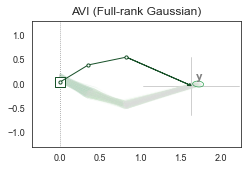

------------------------------------------------------------------------------------------
4_MCMC
torch.Size([1000, 4])
---------------
****************


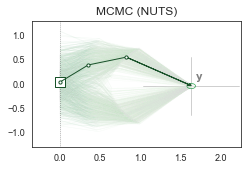

------------------------------------------------------------------------------------------


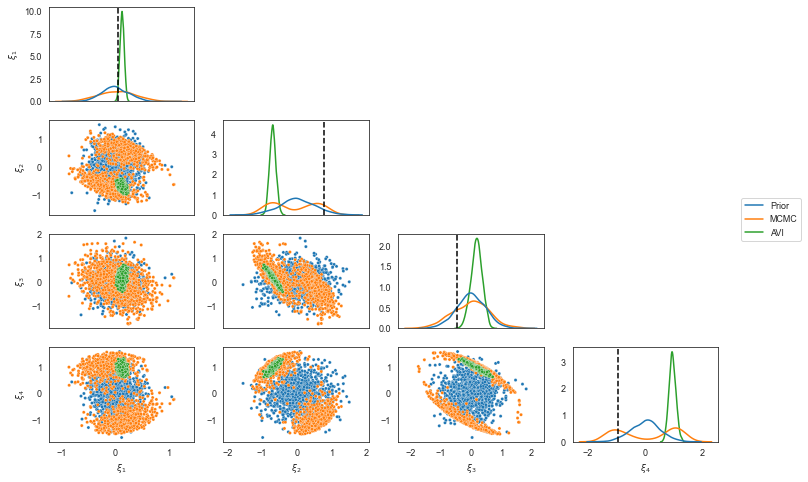

*****************************************************************************************************************************************************************************************


In [18]:
n_samples = 1000 # number of posterior samples

colorlist = [1,0,2,3,2]

for j in range(y_data_.shape[0]):
    print(j)
    
    # Getting data
    xi_data, y_data = xi_data_[j].reshape(1,-1), y_data_[j].reshape(1,-1)
    print('Groundtruth:\n xi_data='+str(xi_data.data.numpy())+',\n y_data='+str(y_data.data.numpy()))
    
    # color selection for plotting
    prior=False
    if prior:
        color_code = 4
    else:
        color_code = colorlist[j] #random.randint(0, 3) #j+1 

    print(str(j)+'_AVI')
    # AVI_Full-rank-Gaussian
    mean = (model.mu(y_data))[0, :]
    L_diag = model.L_diag(y_data)
    L_offdiag = model.L_offdiag(y_data) #or 0.01*self.L_offdiag(y)
    L = unpack_cholesky(L_diag[0,:], L_offdiag[0,:], model.xi_dim) # L matrix

    print('Estimated mean:\n'+str(mean.data.numpy()))
    print('Estimated covariance matrix:\n'+str(torch.matmul(L,L.T).data.numpy()))

    xi_samples_AVI = torch.zeros(n_samples,model.xi_dim)
    for k in range(n_samples):
        zs = torch.randn_like(mean)
        xi_samples_AVI[k] = mean + torch.matmul(L, zs)
    print(xi_samples_AVI.shape)

    plot(xi_samples_AVI, xi_data, y_data, str(j)+'_AVI', "AVI (Full-rank Gaussian)", color_code)
    print('-'*90)

    print(str(j)+'_MCMC')
    # MCMC
    def model_MCMC(data):
        xi = pyro.sample( "input", dist_pyro.Normal(loc=torch.zeros(len(prior_scale)), scale=prior_scale) )
        pyro.sample("obs", dist_pyro.Normal(forward_process(xi)['D'].flatten(), scale=noise_scale), obs=data)

    hmc_kernel = HMC(model_MCMC, step_size=0.0855, num_steps=4)
    nuts_kernel= NUTS(model_MCMC, adapt_step_size=True)
    mcmc = MCMC(nuts_kernel, num_samples=int(n_samples*3), warmup_steps=300, num_chains=1)
    mcmc.run(y_data[0])
    
    thin = 3 #adjacent MCMC samples are correlated so computationally it can make sense to throw some samples out.
    xi_samples_MCMC = mcmc.get_samples()['input'][::thin,:]
    print(xi_samples_MCMC.shape)

    #print(mcmc.summary())
    plot(xi_samples_MCMC, xi_data, y_data, str(j)+'_MCMC', "MCMC (NUTS)", color_code)
    print('-'*90) 

    ######
    Prior_data = prior_xi_dist.sample([n_samples]).T.data.numpy()
    Prior_dict = dict() 
    for i in range(Prior_data.shape[0]):
        Prior_dict[r'$\xi_{%.0f}$' % (i+1)] = Prior_data[i] 

    AVI_data = xi_samples_AVI.T.data.numpy()
    AVI_dict = dict() 
    for i in range(AVI_data.shape[0]):
        AVI_dict[r'$\xi_{%.0f}$' % (i+1)] = AVI_data[i]  

    MCMC_data = xi_samples_MCMC.T.data.numpy()
    MCMC_dict = dict() 
    for i in range(MCMC_data.shape[0]):
        MCMC_dict[r'$\xi_{%.0f}$' % (i+1)] = MCMC_data[i]    

    df_Prior = pd.DataFrame(Prior_dict)
    df_MCMC = pd.DataFrame(MCMC_dict)
    df_AVI = pd.DataFrame(AVI_dict)
    df_Prior['Sample type'] = 'Prior'
    df_MCMC['Sample type'] = 'MCMC'
    df_AVI['Sample type'] = 'AVI'

    df = pd.concat([df_Prior, df_MCMC, df_AVI])
    df.reset_index(drop=True, inplace=True)
    pair_plot(df, xi_data, j)
    ######   
    
    print('*'*185) 

In [19]:
!zip -r ./results.zip ./results

  adding: results/ (stored 0%)
  adding: results/3_MCMC_plot.pdf (deflated 2%)
  adding: results/3_AVI_xi_samples.pt (deflated 10%)
  adding: results/2_AVI_xi_samples.pt (deflated 10%)
  adding: results/4_MCMC_plot.pdf (deflated 1%)
  adding: results/0_MCMC_plot.pdf (deflated 5%)
  adding: results/4_pairplot.pdf (deflated 3%)
  adding: results/3_pairplot.pdf (deflated 3%)
  adding: results/1_AVI_xi_samples.pt (deflated 10%)
  adding: results/0_MCMC_xi_samples.pt (deflated 9%)
  adding: results/1_AVI_plot.pdf (deflated 11%)
  adding: results/4_AVI_xi_samples.pt (deflated 10%)
  adding: results/3_MCMC_xi_samples.pt (deflated 8%)
  adding: results/2_pairplot.pdf (deflated 3%)
  adding: results/0_AVI_xi_samples.pt (deflated 13%)
  adding: results/0_AVI_plot.pdf (deflated 12%)
  adding: results/2_MCMC_xi_samples.pt (deflated 8%)
  adding: results/xi_data.pt (deflated 48%)
  adding: results/0_pairplot.pdf (deflated 3%)
  adding: results/2_AVI_plot.pdf (deflated 12%)
  adding: results/1_pairp